In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import datetime
from collections import namedtuple
import seaborn as sns

In [2]:
mypath = r"Stats"
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

print(onlyfiles)

['atpqp_Profile-Visual+Weste+Thermal+Sound_22_12_16__13_36.csv', 'atpqp_Profile-Visual+Weste+Thermal_22_12_16__14_34.csv', 'atpqp_Profile-Visual+Weste_22_12_16__14_18.csv', 'atpqp_Profile-Visual_22_12_16__14_01.csv', 'auffz_Profile-Visual+Weste+Thermal+Sound_22_12_07__15_09.csv', 'auffz_Profile-Visual+Weste+Thermal_22_12_07__14_53.csv', 'auffz_Profile-Visual+Weste_22_12_07__14_27.csv', 'auffz_Profile-Visual+Weste_22_12_07__14_32.csv', 'auffz_Profile-Visual_22_12_07__14_08.csv', 'dycnh_Profile-Visual+Weste+Thermal+Sound_22_11_30__22_52.csv', 'dycnh_Profile-Visual+Weste+Thermal_22_11_30__22_32.csv', 'dycnh_Profile-Visual+Weste_22_11_30__22_21.csv', 'dycnh_Profile-Visual_22_11_30__22_03.csv', 'easva_Profile-Visual+Weste+Thermal+Sound_22_12_16__12_23.csv', 'easva_Profile-Visual+Weste+Thermal_22_12_16__11_54.csv', 'easva_Profile-Visual+Weste_22_12_16__12_55.csv', 'easva_Profile-Visual_22_12_16__12_41.csv', 'hnkgs_Profile-Visual+Weste+Thermal+Sound_22_12_09__13_30.csv', 'hnkgs_Profile-Visual

In [3]:
# This isn't dynamic, I don't care it doesn't matter
ABCD_playertags = ["dycnh", "juheo", "auffz"]
BCDA_playertags = ["lnlqi","zegfw", "liqox"]
CDAB_playertags = ["yicwd", "easva", "hrzup"]
DABC_playertags = ["hnkgs","twkfm", "atpqp"]

short_name = {"Profile-Visual": "A", "Profile-Visual+Weste" : "B", "Profile-Visual+Weste+Thermal" : "C", "Profile-Visual+Weste+Thermal+Sound" : "D"}
played_first = {"A": ABCD_playertags, "B":BCDA_playertags, "C": CDAB_playertags, "D": DABC_playertags}

In [4]:
#df = pd.read_csv(os.path.join(mypath, onlyfiles[0]))

def condenseStats(file, loud = False):
    
    stats_dict = {}
    
    df = pd.read_csv(os.path.join(mypath, file))
    #preprocess gametime
    
    stats_dict["player_tag"] = df["Player"][0]
    stats_dict["profile"] = df["Profile"][0]
    
    t = np.array(df["Time"], )
    t = t.astype(datetime)

    t = np.array([datetime.strptime(my_date_string, '%Y-%m-%d %H:%M:%S.%f') for my_date_string in t])

    start_time = t[0]
    t = t - start_time

    t = np.array([int(timesince.total_seconds()) for timesince in t]) 
    df["GameTime"] = t
    
    time_played = t[-1]
    time_played_min = time_played / 60
    
    stats_dict["time_played_sec"] = time_played
    stats_dict["time_played_min"] = time_played_min
    if loud:
        print(f"time played {time_played} seconds. {time_played_min} minutes")
        print("\nplayer damaging enemies")
        
    events= ("killed an enemy", "enemy_headshot")
    for e in events:
        df_event = df.loc[df["Event"]==e]
        stats_dict[e+"_total"]=len(df_event)
        stats_dict[e+"_per_minute"]=len(df_event)/time_played_min
        if loud:
            print(e, len(df_event), "  |  ", len(df_event)/time_played_min, " per minute")
        
    df_event = df.loc[df["Event"].str.contains("weapon_fired", case = False)]
    stats_dict["weapon_fired_total"] = len(df_event)
    stats_dict["weapon_fired_per_minute"] = len(df_event)/time_played_min
    if loud:
        print("weapon_fired", len(df_event), "  |  ", len(df_event)/time_played_min)
    l = np.array(df_event["Event"])
    l = np.array([st.split(" ")[-1] for st in l], int).astype(int)
    stats_dict["hits_total"] = l.sum()
    stats_dict["hits_per_minute"] = l.sum()/time_played_min
    stats_dict["accuracy"] = l.sum()/len(df_event)
    if loud:
        print("hits",l.sum(),  "  |  ", l.sum()/time_played_min, " per minute")
        print("accuracy is ", l.sum()/len(df_event))
    
    
        print("\nplayer taking damage")
    
    events= ("shielded hit", "unshielded hit", "tased", "auto regenerate armor", "auto replenish health", "downed", "revived by ally")
    for e in events:
        df_event = df.loc[df["Event"]==e]
        stats_dict[e+"_total"] = len(df_event)
        stats_dict[e+"_per_minute"]=len(df_event)/time_played_min
        if loud:
            print(e, len(df_event),  "  |  ", len(df_event)/time_played_min, " per minute")
    
    
    eventContains = ("complete_objective", "activate_objective")
    for e in eventContains:
        df_event = df.loc[df["Event"].str.contains(e, case = False)]
        stats_dict[e+"_total"] = len(df_event)
        stats_dict[e+"_per_minute"]=len(df_event)/time_played_min
        if loud:
            print(e, len(df_event), "  |  ", len(df_event)/time_played_min, " per minute")
        
    # average hp value
    
    df_hp = df.loc[df["Event"].str.contains("hp", case = False)]
    hp = np.array([int(ev.replace("hp ","")) for ev in df_hp["Event"]])
    hp_max = np.max(hp)
    #hp = hp/hp_max
    stats_dict["average_hp"]=np.average(hp)
    if loud:
        print(f"average Hp is {np.average(hp)}")
        
    # player armor
    df_armor = df.loc[df["Event"].str.contains("armor", case = False)]
    df_armor = df_armor.loc[~df_armor["Event"].str.contains("regenerate armor", case = False)]
    armor = np.array([int(ev.replace("armor ","")) for ev in df_armor["Event"]])
    armor_max = np.max(armor)
    #armor = armor/armor_max
    stats_dict["average_armor"]= np.average(armor)
    if loud:
        print(f"Average Armor is {np.average(armor)}")
    
    # total health lost
    
    def total_value_lost(li):
        peak = li[0]
        valley = li[0]
        last = li[0]
        climbing = True
        
        lost = 0
        
        for val in li:
            #print(val)
            if climbing:
                if last <= val: # going up
                    peak = val # finding value of peak
                else: #last >= val going down
                    valley = val 
                    climbing = False
                    # we switch direction. peak found
            else:
                if last >= val:
                    valley = val # finding value of valley
                else:
                    # found a valley. next climb again
                    lost = lost + (peak - valley)
                    #print(f"found valley peak: {peak} valley: {valley}. total now: {lost}")
                    peak = val
                    climbing = True
            last = val
        return lost
            
    #print(f"total hp lost {total_value_lost(hp)}   |    {total_value_lost(hp)/time_played_min}")
    stats_dict["armor_lost_total"] = total_value_lost(armor)
    stats_dict["armor_lost_per_min"] = total_value_lost(armor)/time_played_min
    if loud:
        print(f"total armor lost {total_value_lost(armor)}    |     {total_value_lost(armor)/time_played_min} per minute")
    
    #fig, ax=plt.subplots(figsize=(15,10))
    #ax.plot(df_hp["GameTime"], hp, label="hp", linewidth=4.0, color='orange')
    
    hp_lost = df.loc[df["Event"].str.contains("health_subtracted", case = False)]
    hp_lost = np.array([float(ev.replace("health_subtracted ","")) for ev in hp_lost["Event"]])
    stats_dict["hp_lost_total"] = int(np.sum(hp_lost)*10)
    stats_dict["hp_lost_per_minute"] = int(np.sum(hp_lost)*10) / time_played_min
    if loud:
        print(f"total hp lost {int(np.sum(hp_lost)*10)}     |     {int(np.sum(hp_lost)*10) / time_played_min} per minute")
    
    # how much time spend on full armor?
    
    armor_time = np.array(df_armor["GameTime"])
    
    def time_spent_at_max_value(values, time, max_value, starts_with_interval):
        #print(f"\nfinding time spend at max value {max_value}")
        interval_start = 0
        end_time = 0
        is_max_val = starts_with_interval
        total_max_val_time = 0
        interval_entries= 0
        for val, t in zip(values,time):
            #print(f"{t} : {val}")
            if is_max_val:
                if val == max_value:
                    end_time = t
                    #print(f"{t} is max, extending interval")
                else:
                    total_max_val_time = total_max_val_time + ( end_time - interval_start )
                    #print(f"{t} end of interval found. {end_time} - {interval_start}")
                    interval_start = t
                    end_time = t
                    is_max_val = False
            else:
                if val == max_value:
                    #print(f"{t} starting interval {val}")
                    interval_start = t
                    end_time = t
                    is_max_val = True
                    interval_entries = interval_entries + 1
                #else:
                    #print(f"{t} is not max, no interval")
        #print(f"interval_entires {interval_entries}")
        return total_max_val_time
                    
    total_max_armor_time = time_spent_at_max_value(armor, armor_time, armor_max, True)
    stats_dict["time_spend_with_max_armor"] = total_max_armor_time
    stats_dict["time_spend_with_max_armor_percentage"] = (total_max_armor_time / time_played)* 100
    if loud:
        print(f"time spend with max armor : {total_max_armor_time}    |      {(total_max_armor_time / time_played)* 100} % of the game")
    
    # time spent crouching
    df_crouching = df.loc[df["Event"].str.contains("stance_crouched", case = False)]
    crouching = np.array([int (ev.replace("stance_crouched ","")) for ev in df_crouching["Event"]])
    crouching_time = np.array(df_crouching["GameTime"])
    total_crouching_time = time_spent_at_max_value(crouching, crouching_time, 1, False)
    stats_dict["time_spend_crouched"] = total_crouching_time
    stats_dict["time_spend_crouched_percentage"] = (total_crouching_time / time_played) * 100
    if loud:
        print(f"time spend crouched: {total_crouching_time}      |     {(total_crouching_time / time_played) * 100} % of the game")
    
    return stats_dict

#condenseStats("atpqp_Profile-Visual+Weste+Thermal+Sound_22_12_16__13_36.csv")

In [5]:
stats_df = pd.DataFrame()
stats_df["stat"] = condenseStats(onlyfiles[0]).keys()
for f in onlyfiles:
    stats_dict = condenseStats(f)
    #print(stats_dict.values())
    stats_df[stats_dict["player_tag"]+" "+ stats_dict["profile"]] = stats_dict.values()
stats_df

,stat,atpqp Profile-Visual+Weste+Thermal+Sound,atpqp Profile-Visual+Weste+Thermal,atpqp Profile-Visual+Weste,atpqp Profile-Visual,auffz Profile-Visual+Weste+Thermal+Sound,auffz Profile-Visual+Weste+Thermal,auffz Profile-Visual+Weste,auffz Profile-Visual,dycnh Profile-Visual+Weste+Thermal+Sound,...,twkfm Profile-Visual+Weste,twkfm Profile-Visual,yicwd Profile-Visual+Weste+Thermal+Sound,yicwd Profile-Visual+Weste+Thermal,yicwd Profile-Visual+Weste,yicwd Profile-Visual,zegfw Profile-Visual+Weste+Thermal+Sound,zegfw Profile-Visual+Weste+Thermal,zegfw Profile-Visual+Weste,zegfw Profile-Visual
0,player_tag,atpqp,atpqp,atpqp,atpqp,auffz,auffz,auffz,auffz,dycnh,...,twkfm,twkfm,yicwd,yicwd,yicwd,yicwd,zegfw,zegfw,zegfw,zegfw
1,profile,Profile-Visual+Weste+Thermal+Sound,Profile-Visual+Weste+Thermal,Profile-Visual+Weste,Profile-Visual,Profile-Visual+Weste+Thermal+Sound,Profile-Visual+Weste+Thermal,Profile-Visual+Weste,Profile-Visual,Profile-Visual+Weste+Thermal+Sound,...,Profile-Visual+Weste,Profile-Visual,Profile-Visual+Weste+Thermal+Sound,Profile-Visual+Weste+Thermal,Profile-Visual+Weste,Profile-Visual,Profile-Visual+Weste+Thermal+Sound,Profile-Visual+Weste+Thermal,Profile-Visual+Weste,Profile-Visual
2,time_played_sec,942,751,818,907,819,699,814,930,738,...,744,730,643,768,740,790,861,964,1106,903
3,time_played_min,15.7,12.516667,13.633333,15.116667,13.65,11.65,13.566667,15.5,12.3,...,12.4,12.166667,10.716667,12.8,12.333333,13.166667,14.35,16.066667,18.433333,15.05
4,killed an enemy_total,118,75,80,117,139,103,132,112,112,...,141,135,80,97,99,86,160,173,158,149
5,killed an enemy_per_minute,7.515924,5.992011,5.867971,7.739802,10.18315,8.841202,9.72973,7.225806,9.105691,...,11.370968,11.09589,7.465008,7.578125,8.027027,6.531646,11.149826,10.767635,8.571429,9.900332
6,enemy_headshot_total,50,23,30,37,39,34,33,36,68,...,42,42,60,72,77,71,44,46,36,40
7,enemy_headshot_per_minute,3.184713,1.83755,2.200489,2.44763,2.857143,2.918455,2.432432,2.322581,5.528455,...,3.387097,3.452055,5.598756,5.625,6.243243,5.392405,3.066202,2.863071,1.952984,2.657807
8,weapon_fired_total,1034,646,716,1094,1739,1187,1439,1338,532,...,977,769,248,337,332,305,1626,1688,1516,1651
9,weapon_fired_per_minute,65.859873,51.611185,52.518337,72.370452,127.399267,101.888412,106.068796,86.322581,43.252033,...,78.790323,63.205479,23.141524,26.328125,26.918919,23.164557,113.310105,105.062241,82.242315,109.700997


In [6]:
# join all the versions, ignores which one was started with
#https://thispointer.com/pandas-select-columns-based-on-conditions-in-dataframe/
averages_df = pd.DataFrame()
averages_df["stat"] = stats_df["stat"].drop([0,1])

for p in ["Profile-Visual", "Profile-Visual+Weste", "Profile-Visual+Weste+Thermal", "Profile-Visual+Weste+Thermal+Sound"]:
    filter_ = (stats_df == p).any()
    sub_df = stats_df.loc[:,filter_]
    sub_df = sub_df.drop([0,1]) # dont need player tag and profile anymore
    mean_df = sub_df.mean(axis = 1)
    averages_df[short_name[p]] = mean_df
    
    std_df = sub_df.std(axis = 1)
    averages_df[short_name[p]+" std"] = std_df


averages_df



,stat,A,A std,B,B std,C,C std,D,D std
2,time_played_sec,819.333333,103.583373,858.083333,216.135252,883.666667,293.337328,833.750000,139.236310
3,time_played_min,13.655556,1.726390,14.301389,3.602254,14.727778,4.888955,13.895833,2.320605
4,killed an enemy_total,105.833333,33.758052,109.000000,29.588081,121.250000,41.299626,106.666667,26.379515
5,killed an enemy_per_minute,7.674190,2.156755,7.839961,2.057942,8.375237,2.176150,7.775449,1.882454
6,enemy_headshot_total,42.583333,14.712137,42.333333,15.569979,48.500000,20.549276,44.250000,13.765074
7,enemy_headshot_per_minute,3.135214,1.096176,3.114532,1.359933,3.459812,1.354091,3.324185,1.298235
8,weapon_fired_total,871.916667,418.797295,904.166667,380.919899,1019.666667,488.692566,917.083333,455.596803
9,weapon_fired_per_minute,62.330862,25.458054,63.085152,22.028046,68.311659,23.700940,64.467685,29.606624
10,hits_total,131.333333,43.731273,133.750000,36.564078,153.166667,57.772018,130.416667,38.615725
11,hits_per_minute,9.519303,2.738292,9.605908,2.499234,10.459588,2.695095,9.446738,2.625678


In [7]:
# as first version played

averages_df = pd.DataFrame()
averages_df["stat"] = stats_df["stat"].drop([0,1])

for p in ["Profile-Visual", "Profile-Visual+Weste", "Profile-Visual+Weste+Thermal", "Profile-Visual+Weste+Thermal+Sound"]:
    filter_ = (stats_df == p).any() # get every session with profile p
    sub_df = stats_df.loc[:,filter_]
    
    players_who_played_version_first = played_first[short_name[p]]
    print(p,players_who_played_version_first)
    starts_with_this_profile_filter = (sub_df == players_who_played_version_first[0]).any()
    for i in range(1,len(players_who_played_version_first)):
        starts_with_this_profile_filter = starts_with_this_profile_filter | (sub_df == players_who_played_version_first[i]).any()
    sub_df = sub_df.loc[:,starts_with_this_profile_filter]
    
    #print(sub_df)
    sub_df = sub_df.drop([0,1]) # dont need player tag and profile anymore
    mean_df = sub_df.mean(axis = 1)
    averages_df["1"+short_name[p]] = mean_df
    
    std_df = sub_df.std(axis = 1)
    averages_df["1"+short_name[p]+" std"] = std_df


averages_df


Profile-Visual ['dycnh', 'juheo', 'auffz']
Profile-Visual+Weste ['lnlqi', 'zegfw', 'liqox']
Profile-Visual+Weste+Thermal ['yicwd', 'easva', 'hrzup']
Profile-Visual+Weste+Thermal+Sound ['hnkgs', 'twkfm', 'atpqp']


,stat,1A,1A std,1B,1B std,1C,1C std,1D,1D std
2,time_played_sec,939.666667,26.839026,1126.333333,229.177515,979.666667,345.193183,825.666667,128.958650
3,time_played_min,15.661111,0.447317,18.772222,3.819625,16.327778,5.753220,13.761111,2.149311
4,killed an enemy_total,124.000000,18.248288,112.333333,41.186567,128.000000,57.192657,110.000000,23.065125
5,killed an enemy_per_minute,7.935340,1.327484,6.055058,2.208339,7.687240,0.711530,7.969591,0.945658
6,enemy_headshot_total,45.000000,10.148892,34.000000,18.083141,68.333333,32.654760,50.000000,7.000000
7,enemy_headshot_per_minute,2.879507,0.693402,1.728644,0.654772,4.169368,1.531138,3.657730,0.432514
8,weapon_fired_total,1077.666667,347.549037,1223.000000,350.298444,846.000000,658.726802,881.000000,195.317690
9,weapon_fired_per_minute,69.233164,23.645461,65.117531,14.894466,47.262801,21.469979,63.554867,5.081606
10,hits_total,151.000000,28.354894,142.333333,49.095146,158.666667,79.908281,131.666667,24.785749
11,hits_per_minute,9.674642,2.046332,7.684541,2.659302,9.426907,1.833960,9.576317,1.170943


In [8]:
import seaborn as sns

def plot_questionnaire_sns(dataa, column , xlabels = None, figurename = None, label = None) :
    
    fig, ax=plt.subplots()
    sns.set(style = "whitegrid")
    sns.boxplot(order = column, data=dataa, showfliers = False, color = "white", medianprops={"color": "red"}, showmeans=False, 
                     meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"}, linewidth = 3, ax = ax)
    sns.swarmplot(order = column, data = dataa, ax = ax, color = "black")
    #ax.set_title(v[column[0]], fontsize = 14);
    if label != None:
        ax.set_xlabel(label, fontsize = 16);
    ax.set_ylabel("");
    ax.set_ylim([0.5,7.5])
    ax.set_yticks([1,2,3,4,5,6,7])
    
    s = dataa.median(axis = 0)
    s.name = "median"
    
    if xlabels != None:
        xlabels = [x+"\n(MD = "+str(s[col])+")" for x,col in zip(xlabels,column)]
        ax.set_xticklabels(xlabels)
    else:
        ticks = [v[col].split(": ")[1] for col in column]
        ax.set_xticklabels(ticks, rotation = 'vertical')
    
    plt.tick_params(axis='both', which='major', labelsize=16)
    #n = "plot_"+v[column[0]]+".png"
    #print(n)
    if figurename is None:
        plt.savefig(f"plot_{v[column[0]].replace(':', '_').replace('?', '').replace('ß','')}.png", bbox_inches='tight')
        print(v[column[0]])
    else:
        plt.savefig(f"plot_{figurename}.png",bbox_inches = 'tight')
        print(figurename)
    plt.show()
    s = dataa.mean(axis = 0)
    s.name = "mean"
    dataa = dataa.append(s)
    s = dataa.std(axis = 0)
    s.name = "std"
    dataa = dataa.append(s)
    display(dataa.loc[["mean","std"],column])
    print("___________________________")
    
    
from scipy.stats import ttest_ind
def check_if_significant(a,b):
    res = ttest_ind(a, b)
    print(res)
    if res.pvalue > 0.05:
        print("ist NICHT significant (p > 0.05). It's the same picture")
    elif res.pvalue < 0.001:
        print("ist SUPER siginifcant (p < 0.001). I've never met this man in my life")
    elif res.pvalue <= 0.05:
        print("ist significant ( p <= 0.05). They are sisters, not twins")

def check_if_significant_list_combinations(s, l):
    for a in l:
        for b in l:
            if a == b:
                continue
            if a in v:
                print(f"{a}: {v[a]} vs. {b}: {v[b]}")
            else:
                print(f"{a} vs. {b}")
            check_if_significant(s.dropna()[a],s.dropna()[b])
            print("\n")

In [9]:
df = pd.read_csv(os.path.join("questionnaire_stats", "variables_schmerz-simulation-pfeifer_2022-12-18_15-04_.csv"),sep = ",", encoding = 'UTF-8', keep_default_na = False)
keys = list(df["VAR"])
values = list(df["LABEL"])

v = {keys[i]: values[i] for i in range(len(keys))}

In [10]:
def plot(my_df, stat_name = "time_spend_crouched"):
    stat_by_profile = pd.DataFrame()
    
    for p in ["Profile-Visual", "Profile-Visual+Weste", "Profile-Visual+Weste+Thermal", "Profile-Visual+Weste+Thermal+Sound"]:
        filter_ = (stats_df == p).any()
        sub_df = stats_df.loc[:,filter_]
        sub_df = sub_df.drop([0,1]) # dont need player tag and profile anymore
        # sub_df contains all playsessions of profile p

        row_of_stat = sub_df.loc[my_df["stat"]==stat_name] # get just the row for the stat we want to visualize
        column_of_stat = row_of_stat.transpose()
        l = np.array(column_of_stat[column_of_stat.columns[0]])
        stat_by_profile[short_name[p]] = l
        #print(stat_by_profile)
        
    #ax = stat_by_profile.mask(stat_by_profile == 0).plot.box(fontsize = 14,)
    
    dataa = stat_by_profile
    fig, ax=plt.subplots(figsize=(7,5))
    sns.set(style = "whitegrid")
    sns.boxplot(data=dataa, showfliers = False, color = "white", medianprops={"color": "red"}, showmeans=False, 
                     meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"}, linewidth = 3, ax = ax)
    sns.swarmplot(data = dataa, ax = ax, color = "black")
    ax.set_title(stat_name, fontsize = 14);
    ax.set_xlabel("Simulations-Versionen", fontsize = 14);
    ax.set_ylabel("");
    #ax.set_ylim([0.5,7.5])
    #ax.set_xticklabels(["A","B","C","D"])
    
    plt.tick_params(axis='both', which='major', labelsize=14)
    print(stat_name)
    plt.show()
    s = stat_by_profile.mean(axis = 0)
    s.name = "mean"
    stat_by_profile = stat_by_profile.append(s)
    display(stat_by_profile)
    check_if_significant_list_combinations(stat_by_profile, stat_by_profile.columns)

#print(stats_df["stat"])
#for stat in list(stats_df["stat"].drop([0,1])):
#    plot(stats_df,stat)

In [11]:
def plot_first_played(my_df, stat_name = "time_spend_crouched"):
    stat_by_profile = pd.DataFrame()
    # join all the versions, ignores which one was started with
    #https://thispointer.com/pandas-select-columns-based-on-conditions-in-dataframe/
    averages_df = pd.DataFrame()
    averages_df["stat"] = stats_df["stat"].drop([0,1])

    for p in ["Profile-Visual", "Profile-Visual+Weste", "Profile-Visual+Weste+Thermal", "Profile-Visual+Weste+Thermal+Sound"]:
        filter_ = (stats_df == p).any()
        sub_df = stats_df.loc[:,filter_]
        
        starts_with_this_profile_filter = (sub_df == players_who_played_version_first[0]).any()
        for i in range(1,len(players_who_played_version_first)):
            starts_with_this_profile_filter = starts_with_this_profile_filter | (sub_df == players_who_played_version_first[i]).any()
        sub_df = sub_df.loc[:,starts_with_this_profile_filter]
        
        sub_df = sub_df.drop([0,1]) # dont need player tag and profile anymore
        # sub_df contains all playsessions of profile p

        row_of_stat = sub_df.loc[my_df["stat"]==stat_name] # get just the row for the stat we want to visualize
        column_of_stat = row_of_stat.transpose()
        #print(column_of_stat)
        l = np.array(column_of_stat[column_of_stat.columns[0]])
        stat_by_profile['1'+short_name[p]] = l
        #print(stat_by_profile)
        
    dataa = stat_by_profile
    fig, ax=plt.subplots(figsize=(7,5))
    sns.set(style = "whitegrid")
    #sns.boxplot(data=dataa, showfliers = False, color = "white", medianprops={"color": "red"}, showmeans=False, 
                     #meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"}, linewidth = 3, ax = ax)
    sns.swarmplot(data = dataa, ax = ax, color = "black")
    ax.set_title(stat_name, fontsize = 14);
    ax.set_xlabel("Simulations-Versionen", fontsize = 14);
    ax.set_ylabel("");
    #ax.set_ylim([0.5,7.5])
    #ax.set_xticklabels(["A","B","C","D"])
    
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()
    #display(stat_by_profile)
    check_if_significant_list_combinations(stat_by_profile, stat_by_profile.columns)

#print(stats_df["stat"])
#for stat in list(stats_df["stat"].drop([0,1])):
#    plot_first_played(stats_df,stat)

In [12]:
df = pd.read_csv(os.path.join("questionnaire_stats", "data_schmerz-simulation-pfeifer_2022-12-21_22-26.csv"),sep = ",", encoding = 'UTF-8', keep_default_na = False)
data = df.loc[:,'BA01_01':'V002_01']
data["QUESTNNR"] = df["QUESTNNR"].replace(['base'], 'ABCD')
data["P102_01"] = data["P102_01"].apply(lambda row: row.lower())
data

,BA01_01,BA02_01,BA03_01,BA04_01,BA05_01,BA05_02,BA05_07,BA06_01,BA06_03,BA06_04,...,IF02_03,IF02_04,IF03_01,IF04_01,IF05_01,IF06_01,IF07_01,P102_01,V002_01,QUESTNNR
0,5,5,1,1,5,7,7,1,7,1,...,7,1,eher keine sobald vibration da war,richtung und häufigkeit,hilfreich bei hoher häufigkeit,hat nerven gekostet.<br>konnte man aber ausble...,7,dycnh,,ABCD
1,1,5,1,1,1,5,3,1,6,1,...,3,5,Leider eher wenig weil ich es nicht so aktiv m...,Durch die Vibrationsveste wusste ich genau wo ...,Das thermische Feedback hat mir mitgeteilt das...,Das auditive Feedback hat mir vorallem direkt ...,7,juheo,Hat sehr viel Spaß gemacht!,ABCD
2,6,6,6,5,5,6,4,4,5,5,...,6,7,Wie viel Schaden ich bekommen habe.,Die information von wo ich angeschossen wurde ...,Das ich mich zurückziehen muss.,das ich einmal getroffen wurde was gut passte ...,4,auffz,Das auditive feedback könnte einen etwas härte...,ABCD
3,4,5,1,1,3,6,3,4,5,3,...,5,4,Ich wurde angeschossen<br>,Von wo wurde ich angeschossen,ich wurde zu viel angegriffen,Ich wurde angeschossen,6,yicwd,Sehr cooles Prinzip<br>Hätte nicht gedacht das...,CDAB
4,6,6,5,6,3,7,1,5,5,5,...,6,4,-Wenn ich Schaden bekommen habe<br>-Wenn ich ...,-Wo sind die Gegner,-Wenn ich zu viele Schaden bekommen habe,-Auditives Feedback war (im Vergleich zu ande...,7,hnkgs,,DABC
5,3,2,1,1,2,6,3,1,6,2,...,7,6,Grobe Richtung der Schadensquelle<br>Stärke de...,Genaue Richtung der Schadensquelle<br><br>Ob i...,Ob ich viel Schaden erlitten habe,Ob meine Rüstung intakt ist oder nicht<br>Welc...,5,twkfm,Mit der Weste getasert zu werden ist sehr inte...,DABC
6,4,3,2,3,1,6,5,2,3,2,...,6,2,Ungefähre Anzahl der Gegner und wellche Art vo...,Wann ich angeschossen werde wieviele Schüsse m...,Signal wenn ich zu viel Schaden erleide,Wenn ich angeschossen werde,4,lnlqi,,BCDA
7,4,3,1,1,2,6,1,2,2,1,...,1,1,Wie viele Gegner von wo ob ich getroffen worde...,Richtung der Gegner wenn ich sie nicht schon g...,das ich viele treffer ab Bekommen habe,das ich getroffen wurde,4,zegfw,Eine normale Runde zum start hatte mich nicht ...,BCDA
8,1,2,1,1,2,7,2,2,1,1,...,7,3,Nur um zu wissen wo ich hin muss und wenn ich ...,Dadurch konnte ich sehr gut wissen von wo ich ...,Das thermische Feedback war das spieleingreife...,Leider merkte ich keinen Unterschied (vielleic...,6,easva,Weste: Die Sensoren fühlen sich mehr wie eine ...,CDAB
9,5,3,2,1,3,5,6,3,4,2,...,6,2,Wenig sie sind mir kaum aufgefallen.,Viele vorallem der Taser war sehr eindeutig. D...,Das Feedback war am stärksten was sinn macht w...,Kaum ich habe es nicht wirklich wahr genommen ...,3,atpqp,,DABC


In [13]:
print(data['DD01_01'].mean())
print(data['DD01_01'].max())
print(data['DD01_01'].min())
data['DD01_01']

23.416666666666668
30
19


0     27
1     20
2     19
3     25
4     21
5     22
6     19
7     20
8     26
9     24
10    28
11    30
Name: DD01_01, dtype: int64

Realism visual vibration thermal sound


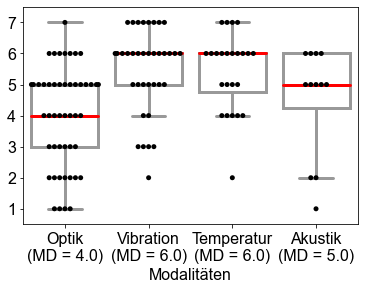

,Realism visual,Realism vibration,Realism thermal,Realism sound
mean,4.000000,5.472222,5.416667,4.500000
std,1.594261,1.343422,1.221907,1.707825


___________________________
Realism visual vs. Realism vibration
Ttest_indResult(statistic=-2.8085236118018986, pvalue=0.010235434246418316)
ist significant ( p <= 0.05). They are sisters, not twins


Realism visual vs. Realism thermal
Ttest_indResult(statistic=-2.578085661834826, pvalue=0.017157322606095926)
ist significant ( p <= 0.05). They are sisters, not twins


Realism visual vs. Realism sound
Ttest_indResult(statistic=-1.0507564985908273, pvalue=0.3047762245614235)
ist NICHT significant (p > 0.05). It's the same picture


Realism vibration vs. Realism visual
Ttest_indResult(statistic=2.8085236118018986, pvalue=0.010235434246418316)
ist significant ( p <= 0.05). They are sisters, not twins


Realism vibration vs. Realism thermal
Ttest_indResult(statistic=0.14788099024669057, pvalue=0.8837836885173427)
ist NICHT significant (p > 0.05). It's the same picture


Realism vibration vs. Realism sound
Ttest_indResult(statistic=1.563471919941143, pvalue=0.13221310479135262)
ist NICHT sig

In [14]:
#plot_questionnaire_sns(data, ['BA01_01', 'BB01_01', 'BB01_02', 'BC01_01', 'BC01_02', 'BC01_03', 'BD01_01', 'BD01_02', 'BD01_03', 'BD01_04'])
#plot_questionnaire_sns(data, ['BA01_01', 'BB01_01', 'BC01_01', 'BD01_01']) # Realismus visuelles Feedback
#plot_questionnaire_sns(data, ['BB01_02', 'BC01_02', 'BD01_02']) Realimus Vibrationsfeedback
#plot_questionnaire_sns(data, ['BC01_03', 'BD01_03',]) # realismus des thermischen feedbacks
#plot_questionnaire_sns(data, ['BD01_04']) # realismus auditives feedback


#put all the datasets together from the different sessions A - visual, b - visual + vibration, c visual + vibration + thermal, d visual + vibration + thermal + sound

realism = pd.DataFrame()
realism["Realism visual"] = data['BA01_01'].append(data['BB01_01']).append(data['BC01_01']).append(data['BD01_01']).reset_index(drop=True)
realism["Realism vibration"] = data['BB01_02'].append(data['BC01_02']).append(data['BD01_02']).reset_index(drop=True)
realism["Realism thermal"] = data['BC01_03'].append(data['BD01_03']).reset_index(drop=True)
realism["Realism sound"] = data['BD01_04']
plot_questionnaire_sns(realism, list(realism.columns), ["Optik", "Vibration", "Temperatur", "Akustik"], "Realism visual vibration thermal sound", "Modalitäten")

#check if the differences are statistically significant.
check_if_significant_list_combinations(realism, realism.columns)


c:\users\mummel\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 39.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


fear visual vibration thermal sound


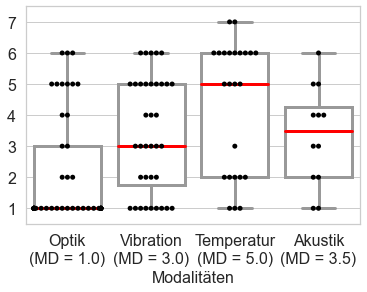

,fear visual,fear vibration,fear thermal,fear sound
mean,2.083333,3.388889,4.333333,3.333333
std,1.730045,1.814720,2.074983,1.545603


___________________________
fear visual vs. fear vibration
Ttest_indResult(statistic=-1.519325895826894, pvalue=0.14292230563178146)
ist NICHT significant (p > 0.05). It's the same picture


fear visual vs. fear thermal
Ttest_indResult(statistic=-3.1522416281896826, pvalue=0.004623234325163741)
ist significant ( p <= 0.05). They are sisters, not twins


fear visual vs. fear sound
Ttest_indResult(statistic=-2.0740682568239692, pvalue=0.049980249672594346)
ist significant ( p <= 0.05). They are sisters, not twins


fear vibration vs. fear visual
Ttest_indResult(statistic=1.519325895826894, pvalue=0.14292230563178146)
ist NICHT significant (p > 0.05). It's the same picture


fear vibration vs. fear thermal
Ttest_indResult(statistic=-1.5173416165766191, pvalue=0.14341992959140373)
ist NICHT significant (p > 0.05). It's the same picture


fear vibration vs. fear sound
Ttest_indResult(statistic=-0.33483993234745874, pvalue=0.7409173645814203)
ist NICHT significant (p > 0.05). It's the same p

In [15]:
#schmerz_befragungen = [c for c in data.columns if '03_' in c and 'B' in c]
#print(schmerz_befragungen)

#plot_questionnaire_sns(data, ['BA03_01', 'BB03_01', 'BB03_02', 'BC03_01', 'BC03_02', 'BC03_03', 'BD03_01', 'BD03_02', 'BD03_03', 'BD03_04'])
#plot_questionnaire_sns(data, ['BA03_01', 'BB03_01', 'BC03_01', 'BD03_01']) # fear visuelles Feedback
#plot_questionnaire_sns(data, ['BB03_02', 'BC03_02', 'BD03_02']) #fear Vibrationsfeedback
#plot_questionnaire_sns(data, ['BC03_03', 'BD03_03',]) # fear des thermischen feedbacks
#plot_questionnaire_sns(data, ['BD03_04']) # fear auditives feedback

vis = [c for c in data.columns if '01_01' in c and 'B' in c]
fear = pd.DataFrame()
fear["fear visual"] = data['BA03_01'].append(data['BB03_01']).append(data['BC03_01']).append(data['BD03_01']).reset_index(drop=True)
fear["fear vibration"] = data['BB03_02'].append(data['BC03_02']).append(data['BD03_02']).reset_index(drop=True)
fear["fear thermal"] = data['BC03_03'].append(data['BD03_03']).reset_index(drop=True)
fear["fear sound"] = data['BD03_04']
plot_questionnaire_sns(fear, list(fear.columns), ["Optik", "Vibration", "Temperatur", "Akustik"], "fear visual vibration thermal sound","Modalitäten")


#check_if_significant_list_combinations(data, ['BC03_03', 'BD03_03'])
check_if_significant_list_combinations(fear, fear.columns)

c:\users\mummel\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 47.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Schmerz visual vibration thermal sound


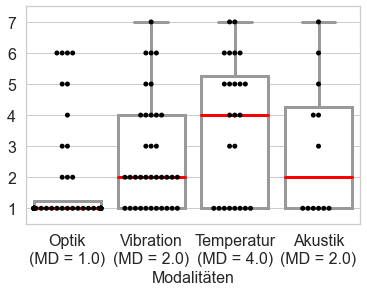

,pain visual,pain vibration,pain thermal,pain sound
mean,1.791667,2.694444,3.708333,2.916667
std,1.593716,1.729153,2.150178,2.139250


___________________________
pain visual vs. pain vibration
Ttest_indResult(statistic=-1.4780016362178865, pvalue=0.1535821615599482)
ist NICHT significant (p > 0.05). It's the same picture


pain visual vs. pain thermal
Ttest_indResult(statistic=-2.1483957239040152, pvalue=0.042949167377636335)
ist significant ( p <= 0.05). They are sisters, not twins


pain visual vs. pain sound
Ttest_indResult(statistic=-1.2121830534626528, pvalue=0.23830033662714387)
ist NICHT significant (p > 0.05). It's the same picture


pain vibration vs. pain visual
Ttest_indResult(statistic=1.4780016362178865, pvalue=0.1535821615599482)
ist NICHT significant (p > 0.05). It's the same picture


pain vibration vs. pain thermal
Ttest_indResult(statistic=-0.813421253311189, pvalue=0.42469301129412285)
ist NICHT significant (p > 0.05). It's the same picture


pain vibration vs. pain sound
Ttest_indResult(statistic=0.10041161847900322, pvalue=0.92092699702963)
ist NICHT significant (p > 0.05). It's the same picture


In [16]:
#plot_questionnaire_sns(data, ['BA04_01', 'BB04_01', 'BB04_02', 'BC04_01', 'BC04_02', 'BC04_03', 'BD04_01', 'BD04_02', 'BD04_03', 'BD04_04'])
#plot_questionnaire_sns(data, ['BA04_01', 'BB04_01', 'BC04_01', 'BD04_01']) # schmerz visuelles Feedback
#plot_questionnaire_sns(data, ['BB04_02', 'BC04_02', 'BD04_02']) #schmerz Vibrationsfeedback
#plot_questionnaire_sns(data, ['BC04_03', 'BD04_03',]) # schmerz des thermischen feedbacks
#plot_questionnaire_sns(data, ['BD04_04']) # schmerz auditives feedback

pain = pd.DataFrame()
pain["pain visual"] = data['BA04_01'].append(data['BB04_01']).append(data['BC04_01']).append(data['BD04_01']).reset_index(drop=True)
pain["pain vibration"] = data['BB04_02'].append(data['BC04_02']).append(data['BD04_02']).reset_index(drop=True)
pain["pain thermal"] = data['BC04_03'].append(data['BD04_03']).reset_index(drop=True)
pain["pain sound"] = data['BD04_04']
plot_questionnaire_sns(pain, list(pain.columns), ["Optik", "Vibration", "Temperatur", "Akustik"], "Schmerz visual vibration thermal sound","Modalitäten")

#check_if_significant_list_combinations(data, ['BC04_03', 'BD04_03',])
check_if_significant_list_combinations(pain, pain.columns)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


pain when no fear visual: 1, 0.020833333333333332
fear when no pain visual: 5, 0.10416666666666667
no fear when no pain visual: 31, 0.6458333333333334


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


pain when no fear vibration: 4, 0.08333333333333333
fear when no pain vibration: 6, 0.125
no fear when no pain vibration: 5, 0.10416666666666667
pain when no fear thermal: 1, 0.020833333333333332
fear when no pain thermal: 6, 0.125
no fear when no pain thermal: 2, 0.041666666666666664
pain when no fear sound: 1, 0.020833333333333332
fear when no pain sound: 5, 0.10416666666666667
no fear when no pain sound: 1, 0.020833333333333332


,fear visual,pain visual,fear vibration,pain vibration,fear thermal,pain thermal,fear sound,pain sound
0,1,1,3.0,2.0,1.0,1.0,1.0,7.0
1,1,1,4.0,4.0,5.0,5.0,5.0,3.0
2,6,5,5.0,6.0,6.0,7.0,6.0,6.0
3,1,1,1.0,2.0,5.0,1.0,2.0,1.0
4,5,6,5.0,5.0,6.0,6.0,1.0,1.0
5,1,1,2.0,1.0,2.0,1.0,3.0,1.0
6,2,3,6.0,3.0,6.0,5.0,4.0,4.0
7,1,1,1.0,2.0,1.0,3.0,4.0,5.0
8,1,1,2.0,2.0,6.0,5.0,2.0,1.0
9,2,1,6.0,2.0,6.0,4.0,5.0,1.0


Index(['fear visual', 'pain visual', 'fear vibration', 'pain vibration',
       'fear thermal', 'pain thermal', 'fear sound', 'pain sound'],
      dtype='object')

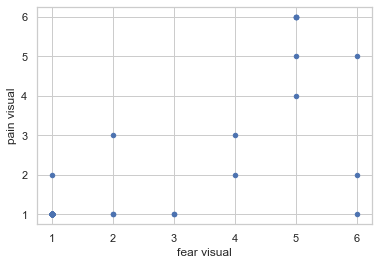

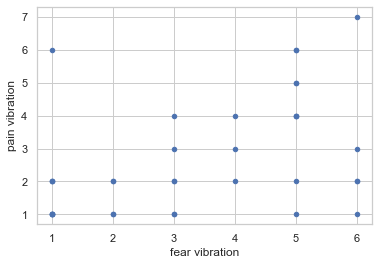

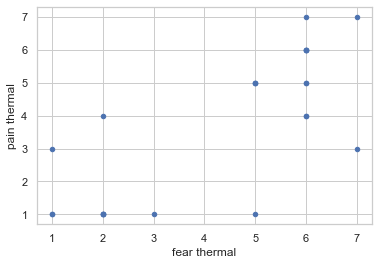

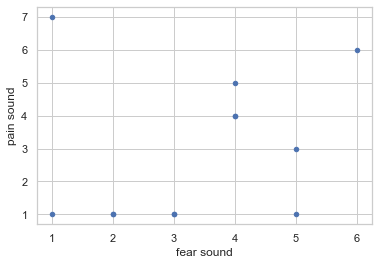

In [17]:
cmp = pd.DataFrame()
cmp["fear visual"] = fear["fear visual"]
cmp["pain visual"] = pain["pain visual"]

cmp["fear vibration"] = fear["fear vibration"]
cmp["pain vibration"] = pain["pain vibration"]

cmp["fear thermal"] = fear["fear thermal"]
cmp["pain thermal"] = pain["pain thermal"]

cmp["fear sound"] = fear["fear sound"]
cmp["pain sound"] = pain["pain sound"]

def fear_pain_korrespondence(modality):
    c = [f != p for f,p in zip(list(cmp["fear "+modality]), list(cmp["pain "+modality])) if f == 1] # wenn fear 1 ist, und pain nicht 1 ist
    pain_when_no_fear = [t for t in c if t]
    p = len(pain_when_no_fear) / len(list(cmp["fear "+modality]))
    print(f"pain when no fear {modality}: {len(pain_when_no_fear)}, {p}")

    c = [f != p for f,p in zip(list(cmp["fear "+modality]), list(cmp["pain "+modality])) if p == 1] # wenn pain 1 ist, und fear nicht 1 ist
    fear_when_no_pain = [t for t in c if t]
    p = len(fear_when_no_pain) / len(list(cmp["fear "+modality]))
    print(f"fear when no pain {modality}: {len(fear_when_no_pain)}, {p}")
    
    c = [f == p for f,p in zip(list(cmp["fear "+modality]), list(cmp["pain "+modality])) if p == 1] # wenn pain 1 ist, und fear nicht 1 ist
    no_fear_no_pain = [t for t in c if t]
    p = len(no_fear_no_pain) / len(list(cmp["fear "+modality]))
    print(f"no fear when no pain {modality}: {len(no_fear_no_pain)}, {p}")
    
    cmp.plot.scatter(x = "fear "+modality, y = "pain "+modality)


fear_pain_korrespondence("visual")
fear_pain_korrespondence("vibration")
fear_pain_korrespondence("thermal")
fear_pain_korrespondence("sound")



display(cmp, cmp.columns)
#display(fear, fear.columns)
#display(pain, pain.columns)

['BA02_01', 'BA05_01', 'BA05_02', 'BA05_07', 'BA06_01', 'BA06_03', 'BA06_04', 'BA06_05', 'BA06_06', 'BA07_01', 'BA08_01', 'BA09_01']
Immersion: Immersion


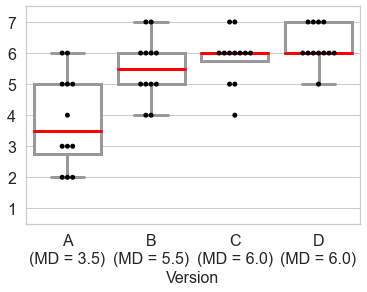

,BA02_01,BB02_01,BC02_01,BD02_01
mean,3.833333,5.500000,5.833333,6.250000
std,1.462494,0.957427,0.799305,0.595119


___________________________
BA02_01: Immersion: Immersion vs. BB02_01: Immersion: Immersion
Ttest_indResult(statistic=-3.162277660168379, pvalue=0.004515546789788395)
ist significant ( p <= 0.05). They are sisters, not twins


BA02_01: Immersion: Immersion vs. BC02_01: Immersion: Immersion
Ttest_indResult(statistic=-3.979949748426479, pvalue=0.0006333474121983688)
ist SUPER siginifcant (p < 0.001). I've never met this man in my life


BA02_01: Immersion: Immersion vs. BD02_01: Immersion: Immersion
Ttest_indResult(statistic=-5.076298083092861, pvalue=4.3805185741188846e-05)
ist SUPER siginifcant (p < 0.001). I've never met this man in my life


BB02_01: Immersion: Immersion vs. BA02_01: Immersion: Immersion
Ttest_indResult(statistic=3.162277660168379, pvalue=0.004515546789788395)
ist significant ( p <= 0.05). They are sisters, not twins


BB02_01: Immersion: Immersion vs. BC02_01: Immersion: Immersion
Ttest_indResult(statistic=-0.8864052604279177, pvalue=0.38498645592833325)
ist NICHT s

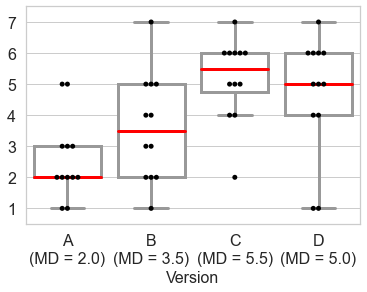

,BA05_01,BB05_01,BC05_01,BD05_01
mean,2.583333,3.583333,5.166667,4.666667
std,1.255543,1.656217,1.280191,1.840894


___________________________
BA05_01: Abschreckung: Ich habe es vermieden angeschossen zu werden damit die Schadensindikatoren nicht ausgelöst werden vs. BB05_01: Abschreckung: Ich habe es vermieden angeschossen zu werden damit die Schadensindikatoren nicht ausgelöst werden
Ttest_indResult(statistic=-1.5958144610863187, pvalue=0.12479619730867714)
ist NICHT significant (p > 0.05). It's the same picture


BA05_01: Abschreckung: Ich habe es vermieden angeschossen zu werden damit die Schadensindikatoren nicht ausgelöst werden vs. BC05_01: Abschreckung: Ich habe es vermieden angeschossen zu werden damit die Schadensindikatoren nicht ausgelöst werden
Ttest_indResult(statistic=-4.7782353936701165, pvalue=9.02576133906866e-05)
ist SUPER siginifcant (p < 0.001). I've never met this man in my life


BA05_01: Abschreckung: Ich habe es vermieden angeschossen zu werden damit die Schadensindikatoren nicht ausgelöst werden vs. BD05_01: Abschreckung: Ich habe es vermieden angeschossen zu werden damit 

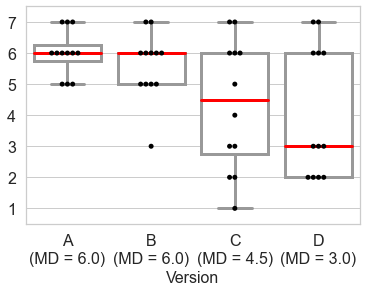

,BA05_02,BB05_02,BC05_02,BD05_02
mean,6.000000,5.583333,4.333333,4.083333
std,0.707107,1.037492,2.013841,2.019007


___________________________
BA05_02: Abschreckung: Gegnerische Schüsse habe ich trotz Schadensindikatoren auch mal ignoriert vs. BB05_02: Abschreckung: Gegnerische Schüsse habe ich trotz Schadensindikatoren auch mal ignoriert
Ttest_indResult(statistic=1.1006605945946253, pvalue=0.28294207622912193)
ist NICHT significant (p > 0.05). It's the same picture


BA05_02: Abschreckung: Gegnerische Schüsse habe ich trotz Schadensindikatoren auch mal ignoriert vs. BC05_02: Abschreckung: Gegnerische Schüsse habe ich trotz Schadensindikatoren auch mal ignoriert
Ttest_indResult(statistic=2.5898488514140614, pvalue=0.016716986619941202)
ist significant ( p <= 0.05). They are sisters, not twins


BA05_02: Abschreckung: Gegnerische Schüsse habe ich trotz Schadensindikatoren auch mal ignoriert vs. BD05_02: Abschreckung: Gegnerische Schüsse habe ich trotz Schadensindikatoren auch mal ignoriert
Ttest_indResult(statistic=2.971539251553055, pvalue=0.007043638070957851)
ist significant ( p <= 0.05). They ar

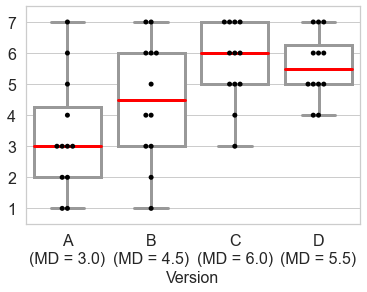

,BA05_07,BB05_07,BC05_07,BD05_07
mean,3.333333,4.500000,5.666667,5.583333
std,1.795055,1.892969,1.247219,1.037492


___________________________
BA05_07: Abschreckung: Ich habe mich häufig hinter Deckung versteckt um nicht getroffen zu werden vs. BB05_07: Abschreckung: Ich habe mich häufig hinter Deckung versteckt um nicht getroffen zu werden
Ttest_indResult(statistic=-1.4832396974191324, pvalue=0.15219615864044428)
ist NICHT significant (p > 0.05). It's the same picture


BA05_07: Abschreckung: Ich habe mich häufig hinter Deckung versteckt um nicht getroffen zu werden vs. BC05_07: Abschreckung: Ich habe mich häufig hinter Deckung versteckt um nicht getroffen zu werden
Ttest_indResult(statistic=-3.540463772012112, pvalue=0.001836674305606734)
ist significant ( p <= 0.05). They are sisters, not twins


BA05_07: Abschreckung: Ich habe mich häufig hinter Deckung versteckt um nicht getroffen zu werden vs. BD05_07: Abschreckung: Ich habe mich häufig hinter Deckung versteckt um nicht getroffen zu werden
Ttest_indResult(statistic=-3.599272947584224, pvalue=0.00159427087186036)
ist significant ( p <= 0.05). 

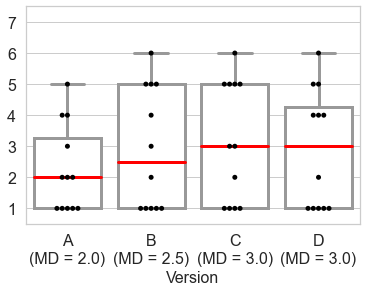

,BA06_01,BB06_01,BC06_01,BD06_01
mean,2.250000,2.916667,3.166667,2.916667
std,1.361678,1.891134,1.863390,1.846543


___________________________
BA06_01: Körperliche Reaktion: Ich konnte mein Herz rasen fühlen vs. BB06_01: Körperliche Reaktion: Ich konnte mein Herz rasen fühlen
Ttest_indResult(statistic=-0.9488180829198518, pvalue=0.353020274295927)
ist NICHT significant (p > 0.05). It's the same picture


BA06_01: Körperliche Reaktion: Ich konnte mein Herz rasen fühlen vs. BC06_01: Körperliche Reaktion: Ich konnte mein Herz rasen fühlen
Ttest_indResult(statistic=-1.317320182850784, pvalue=0.20128718152910002)
ist NICHT significant (p > 0.05). It's the same picture


BA06_01: Körperliche Reaktion: Ich konnte mein Herz rasen fühlen vs. BD06_01: Körperliche Reaktion: Ich konnte mein Herz rasen fühlen
Ttest_indResult(statistic=-0.9637218968452996, pvalue=0.34565980001810215)
ist NICHT significant (p > 0.05). It's the same picture


BB06_01: Körperliche Reaktion: Ich konnte mein Herz rasen fühlen vs. BA06_01: Körperliche Reaktion: Ich konnte mein Herz rasen fühlen
Ttest_indResult(statistic=0.948818082919

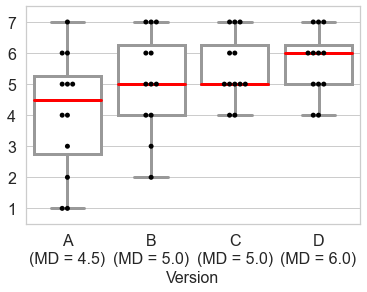

,BA06_03,BB06_03,BC06_03,BD06_03
mean,4.083333,5.083333,5.500000,5.666667
std,1.891134,1.552328,1.040833,1.027402


___________________________
BA06_03: Körperliche Reaktion: Ich habe mich in meinem Körper präsent gefühlt vs. BB06_03: Körperliche Reaktion: Ich habe mich in meinem Körper präsent gefühlt
Ttest_indResult(statistic=-1.3555762637935782, pvalue=0.1889880516646671)
ist NICHT significant (p > 0.05). It's the same picture


BA06_03: Körperliche Reaktion: Ich habe mich in meinem Körper präsent gefühlt vs. BC06_03: Körperliche Reaktion: Ich habe mich in meinem Körper präsent gefühlt
Ttest_indResult(statistic=-2.176626958859232, pvalue=0.04052162978759031)
ist significant ( p <= 0.05). They are sisters, not twins


BA06_03: Körperliche Reaktion: Ich habe mich in meinem Körper präsent gefühlt vs. BD06_03: Körperliche Reaktion: Ich habe mich in meinem Körper präsent gefühlt
Ttest_indResult(statistic=-2.4399842701093, pvalue=0.023205673163458902)
ist significant ( p <= 0.05). They are sisters, not twins


BB06_03: Körperliche Reaktion: Ich habe mich in meinem Körper präsent gefühlt vs. BA06_03: Kö

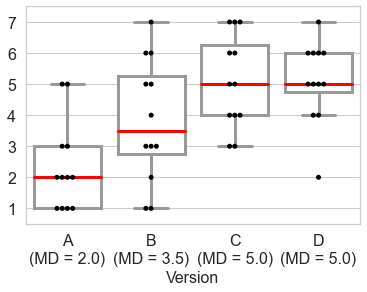

,BA06_04,BB06_04,BC06_04,BD06_04
mean,2.333333,3.833333,5.083333,5.083333
std,1.374369,1.907587,1.440968,1.255543


___________________________
BA06_04: Körperliche Reaktion: Ich hatte das Gefühl mein Körper und meine Spielfigur wären verbunden vs. BB06_04: Körperliche Reaktion: Ich hatte das Gefühl mein Körper und meine Spielfigur wären verbunden
Ttest_indResult(statistic=-2.11598368015289, pvalue=0.04589762251023294)
ist significant ( p <= 0.05). They are sisters, not twins


BA06_04: Körperliche Reaktion: Ich hatte das Gefühl mein Körper und meine Spielfigur wären verbunden vs. BC06_04: Körperliche Reaktion: Ich hatte das Gefühl mein Körper und meine Spielfigur wären verbunden
Ttest_indResult(statistic=-4.5802821133832605, pvalue=0.0001462149842044225)
ist SUPER siginifcant (p < 0.001). I've never met this man in my life


BA06_04: Körperliche Reaktion: Ich hatte das Gefühl mein Körper und meine Spielfigur wären verbunden vs. BD06_04: Körperliche Reaktion: Ich hatte das Gefühl mein Körper und meine Spielfigur wären verbunden
Ttest_indResult(statistic=-4.8995930467793025, pvalue=6.72041628708561e-

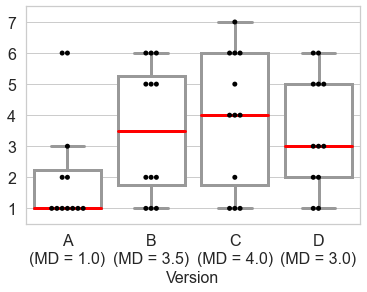

,BA06_05,BB06_05,BC06_05,BD06_05
mean,2.166667,3.500000,3.916667,3.500000
std,1.818119,2.061553,2.099934,1.755942


___________________________
BA06_05: Körperliche Reaktion: Die Schadenindikatoren haben mich nervös gemacht vs. BB06_05: Körperliche Reaktion: Die Schadenindikatoren haben mich nervös gemacht
Ttest_indResult(statistic=-1.6087993330796875, pvalue=0.12191759613313437)
ist NICHT significant (p > 0.05). It's the same picture


BA06_05: Körperliche Reaktion: Die Schadenindikatoren haben mich nervös gemacht vs. BC06_05: Körperliche Reaktion: Die Schadenindikatoren haben mich nervös gemacht
Ttest_indResult(statistic=-2.089578099440977, pvalue=0.04843305337241487)
ist significant ( p <= 0.05). They are sisters, not twins


BA06_05: Körperliche Reaktion: Die Schadenindikatoren haben mich nervös gemacht vs. BD06_05: Körperliche Reaktion: Die Schadenindikatoren haben mich nervös gemacht
Ttest_indResult(statistic=-1.7495340994725972, pvalue=0.09413716496681832)
ist NICHT significant (p > 0.05). It's the same picture


BB06_05: Körperliche Reaktion: Die Schadenindikatoren haben mich nervös gemacht 

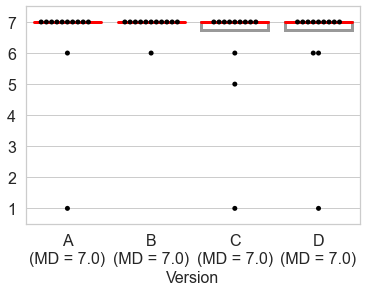

,BA06_06,BB06_06,BC06_06,BD06_06
mean,6.416667,6.916667,6.250000,6.333333
std,1.656217,0.276385,1.689428,1.649916


___________________________
BA06_06: Körperliche Reaktion: Mir war bewusst dass ich nicht in echter Gefahr bin vs. BB06_06: Körperliche Reaktion: Mir war bewusst dass ich nicht in echter Gefahr bin
Ttest_indResult(statistic=-0.98760794758248, pvalue=0.33408288188380164)
ist NICHT significant (p > 0.05). It's the same picture


BA06_06: Körperliche Reaktion: Mir war bewusst dass ich nicht in echter Gefahr bin vs. BC06_06: Körperliche Reaktion: Mir war bewusst dass ich nicht in echter Gefahr bin
Ttest_indResult(statistic=0.23364625124234964, pvalue=0.8174200302960533)
ist NICHT significant (p > 0.05). It's the same picture


BA06_06: Körperliche Reaktion: Mir war bewusst dass ich nicht in echter Gefahr bin vs. BD06_06: Körperliche Reaktion: Mir war bewusst das ich nicht in echter Gefahr bin
Ttest_indResult(statistic=0.11822490573246941, pvalue=0.9069622680250471)
ist NICHT significant (p > 0.05). It's the same picture


BB06_06: Körperliche Reaktion: Mir war bewusst dass ich nicht in ech

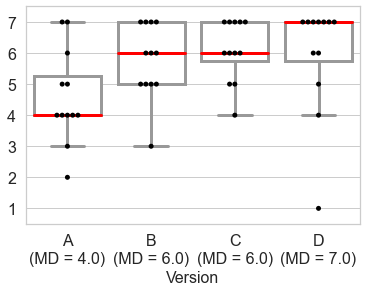

,BA07_01,BB07_01,BC07_01,BD07_01
mean,4.583333,5.750000,6.083333,5.916667
std,1.440968,1.163687,0.953794,1.753964


___________________________
BA07_01: Spaß: Wie viel Spaß hat dir das Spiel mit den Schadensindikatoren gemacht? vs. BB07_01: Spaß: Wie viel Spaß hat dir das Spiel mit den Schadensindikatoren gemacht?
Ttest_indResult(statistic=-2.089108055997973, pvalue=0.048479304130811765)
ist significant ( p <= 0.05). They are sisters, not twins


BA07_01: Spaß: Wie viel Spaß hat dir das Spiel mit den Schadensindikatoren gemacht? vs. BC07_01: Spaß: Wie viel Spaß hat dir das Spiel mit den Schadensindikatoren gemacht?
Ttest_indResult(statistic=-2.8789532981664108, pvalue=0.008715994454006885)
ist significant ( p <= 0.05). They are sisters, not twins


BA07_01: Spaß: Wie viel Spaß hat dir das Spiel mit den Schadensindikatoren gemacht? vs. BD07_01: Spaß: Wie viel Spaß hat dir das Spiel mit den Schadensindikatoren gemacht ?
Ttest_indResult(statistic=-1.9481140233514156, pvalue=0.06427176361089249)
ist NICHT significant (p > 0.05). It's the same picture


BB07_01: Spaß: Wie viel Spaß hat dir das Spiel mit 

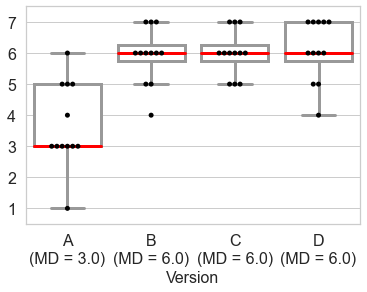

,BA08_01,BB08_01,BC08_01,BD08_01
mean,3.666667,5.916667,6.000000,6.083333
std,1.312335,0.862007,0.707107,0.953794


___________________________
BA08_01: Aufregung: Wie aufregend war das Spiel mit den Schadensindikatoren für Dich? vs. BB08_01: Aufregung: Wie aufregend war das Spiel mit den Schadensindikatoren für Dich?
Ttest_indResult(statistic=-4.752760502525476, pvalue=9.603059267421448e-05)
ist SUPER siginifcant (p < 0.001). I've never met this man in my life


BA08_01: Aufregung: Wie aufregend war das Spiel mit den Schadensindikatoren für Dich? vs. BC08_01: Aufregung: Wie aufregend war das Spiel mit den Schadensindikatoren für Dich?
Ttest_indResult(statistic=-5.191338940966965, pvalue=3.318901249857609e-05)
ist SUPER siginifcant (p < 0.001). I've never met this man in my life


BA08_01: Aufregung: Wie aufregend war das Spiel mit den Schadensindikatoren für Dich? vs. BD08_01: Aufregung: Wie aufregend war das Spiel mit den Schadensindikatoren für Dich?
Ttest_indResult(statistic=-4.940543591170237, pvalue=6.08484742743211e-05)
ist SUPER siginifcant (p < 0.001). I've never met this man in my life


B

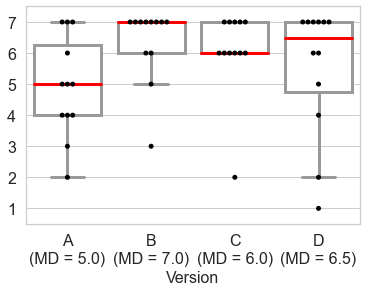

,BA09_01,BB09_01,BC09_01,BD09_01
mean,4.916667,6.333333,6.083333,5.500000
std,1.552328,1.178511,1.320248,2.020726


___________________________
BA09_01: nochmal spielen: Würdest du in deiner Freizeit nochmal ein Spiel mit den verwendeten Schadensindikatoren spielen? vs. BB09_01: nochmal spielen: Würdest du in deiner Freizeit nochmal ein Spiel mit den verwendeten Schadensindikatoren spielen?
Ttest_indResult(statistic=-2.410746810184627, pvalue=0.02471771982279269)
ist significant ( p <= 0.05). They are sisters, not twins


BA09_01: nochmal spielen: Würdest du in deiner Freizeit nochmal ein Spiel mit den verwendeten Schadensindikatoren spielen? vs. BC09_01: nochmal spielen: Würdest du in deiner Freizeit nochmal ein Spiel mit den verwendeten Schadensindikatoren spielen?
Ttest_indResult(statistic=-1.8987762297249666, pvalue=0.07078787350887432)
ist NICHT significant (p > 0.05). It's the same picture


BA09_01: nochmal spielen: Würdest du in deiner Freizeit nochmal ein Spiel mit den verwendeten Schadensindikatoren spielen? vs. BD09_01: nochmal spielen: Würdest du in deiner Freizeit nochmal ein Spiel mit 

In [18]:
def check_correlation(df, columns):
    df.corr(min_periods=3)

befragung = [c for c in data.columns if "BA" in c and '01_' not in c and '03_' not in c and '04_' not in c]
print(befragung)
for var in befragung:
    plot_questionnaire_sns(data, [var, var.replace('A','B'), var.replace('A','C'),var.replace('A','D')], ["A","B","C","D"], None, "Version")
    check_if_significant_list_combinations(data, [var, var.replace('A','B'), var.replace('A','C'),var.replace('A','D')])
    check_correlation(data, [var, var.replace('A','B'), var.replace('A','C'),var.replace('A','D')])


In [19]:
display(data.loc[:,["IF01_01", "IF01_02","IF01_03","IF01_04"]]) #welche modalität fällt am meisten auf ?

,IF01_01,IF01_02,IF01_03,IF01_04
0,1,1,2,2
1,1,2,2,2
2,2,1,2,2
3,1,1,2,2
4,1,1,2,1
5,1,2,2,2
6,1,1,2,2
7,1,1,2,2
8,1,1,2,2
9,1,1,2,1


In [20]:
h_raasen = data.loc[:,["BA06_01", "BB06_01", "BC06_01","BD06_01"]]
print("herz raasen overall")
print(h_raasen.values.flatten().mean(axis = None))
print(h_raasen.values.flatten().std(axis = None))

herz raasen overall
2.8125
1.7871794584390976


Payday2: Wie gut gefällt dir das originale Spiel Payday 2 ohne modifizierte Schadensindikatoren ?


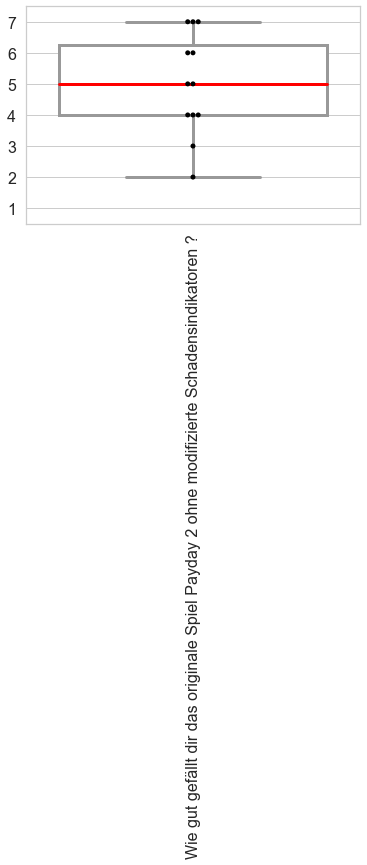

,IF07_01
mean,5.000000
std,1.581139


___________________________


In [21]:
plot_questionnaire_sns(data, ["IF07_01"])

Alter: Alter


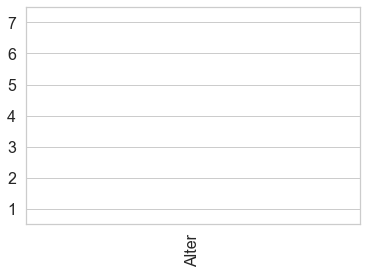

,DD01_01
mean,23.416667
std,3.616129


___________________________


In [22]:
plot_questionnaire_sns(data, ["DD01_01"])

In [23]:
plot_spielstil(data, ["DD02","DD04","DD05_01","DD05_03","DD05_04"])

NameError: name 'plot_spielstil' is not defined

In [ ]:
plot_questionnaire_sns(data, ["IF02_01", "IF02_02","IF02_03","IF02_04"])
# am meisten informationen über weste. auch einiges über thermisches feedback
# weste feedback haben alle außer einer person haben 7 gesagt. eine hat 5 gesagt.
# thermisches feedback viele sehr hoch bewerten zwischen 7 und 5. wenige haben es als niedrig bewertet.
check_if_significant_list_combinations(data, ["IF02_01", "IF02_02","IF02_03","IF02_04"])

In [ ]:
plot_questionnaire_sns(data, ["IF07_01"])

In [ ]:
# welche sind am meisten aufgefallen? 
column = ["IF01_01", "IF01_02", "IF01_03", "IF01_04", "IF01_06"]
plot_questionnaire_sns(data, column)
# visual, auditory, vibration, thermal, nichts
#count of these

In [ ]:
def plot_spielstil(dataa, column) :
    
    fig, ax=plt.subplots(figsize = (15,8))
    sns.set(style = "whitegrid")
    sns.boxplot(order = column, data=dataa, showfliers = False, color = "white", medianprops={"color": "red"}, showmeans=False, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"}, linewidth = 3, ax = ax)
    sns.swarmplot(order = column, data = dataa, ax = ax, color = "black")
    #ax.set_title(v[column[0]], fontsize = 14);
    ax.set_xlabel("Simulations-Versionen", fontsize = 14);
    ax.set_ylabel("");
    ax.set_ylim([0.5,7.5])
    ticks = [v[col].split(": ")[1] if ':' in v[col] else v[col] for col in column]
    ax.set_xticklabels(ticks, rotation = 'vertical')
    
    plt.tick_params(axis='both', which='major', labelsize=14)
    #n = "plot_"+v[column[0]]+".png"
    #print(n)
    plt.savefig(f"plot_{v[column[0]].replace(':', '_').replace('?', '').replace('ß','')}.png", bbox_inches='tight')
    print(v[column[0]])
    plt.show()
    s = dataa.mean(axis = 0)
    s.name = "mean"
    dataa = dataa.append(s)
    s = dataa.std(axis = 0)
    s.name = "std"
    dataa = dataa.append(s)
    display(dataa.loc[:,column])
    print("___________________________")


spielstil = [c for c in data.columns if "BD10" in c]
plot_spielstil(data, spielstil)

In [ ]:
spielstil = [c for c in data.columns if "IF02" in c]
plot_spielstil(data, spielstil)

In [ ]:
spielstil = [c for c in data.columns if "DD" in c and 'DD01' not in c]
plot_spielstil(data, spielstil)

In [ ]:
display(data.loc[:,["IF03_01","IF04_01","IF05_01","IF06_01"]])